# Document Classification using Preprocessed Data

This notebook provides a workflow for classifying documents into different categories using preprocessed OCR text. The notebook skips the preprocessing step and starts directly with the DataFrame.

## Table of Contents
1. Data Loading
2. Feature Extraction
3. Model Testing and Comparison
4. Model Optimization
5. Visualizations

### 1. Data Loading
In this section, we load the DataFrame from a pickle file located at `./../data/raw/df.pkl`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve

# Load & Display Data
df = pd.read_pickle('./../data/raw/df.pkl')

sample_df = pd.DataFrame(columns=df.columns)
for target_class in range(16):
    class_sample = df[df['target'] == target_class].sample(n=62, random_state=42)
    sample_df = pd.concat([sample_df, class_sample], ignore_index=True)

sample_df['target'] = sample_df['target'].astype(int)

sample_df.head(100)

/Users/quentinpizenberg/Developer/repo/git_projects/mai24_bds_extraction_info/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,target,ocr_text,clean_text
0,0,if SEGRE = ads ee Hg if a aul i enue Hee Hea a...,segre ad aul enue hee hea aye eile mii ine aga...
1,0,"Tur Councit ror Topacco ResmarcH-U.S.A., Inc. ...",tur councit ror topacco inc support biomedical...
2,0,Date Commissioner David Kessler Dockets Manag...,date commissioner david kessler docket managem...
3,0,"4OCVD, _ Li MU Tobacco Company GARY L_ LOSER...",tobacco company gary loser onal manager trade ...
4,0,"PHILIP MORRIS usa. 120 PARK AVENUE, NEW YORK,...",philip morris usa park avenue new york telepho...
...,...,...,...
95,1,rae sn n tie | Fx ents par: 33 1 47381798 PH...,rae tie ent par philip morris norm dre philip ...
96,1,Vertragsforschung INBIFO een FEET s Forschung...,vertragsforschung inbifo een foot forschung gm...
97,1,From: To: COUPON CODE REGISTRATION FORM H. ...,coupon code registration form kelli alexander ...
98,1,RECORD TRANSFER REQUEST scr # 2054934865 DA...,record transfer request scr date leave blank g...


### 2. Feature Extraction
We convert the preprocessed text (`clean_text`) into numerical features using TF-IDF Vectorization.

In [2]:
# Use TfidfVectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(sample_df['clean_text'])

# Extract target labels
y = sample_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Model Testing and Comparison
We test and compare multiple models including Logistic Regression, SVM, Naive Bayes, Random Forest and Decision Tree.

In [3]:
# Define a function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    return f1, accuracy

# Initialize models
models = {
    "Logistic Regression": LogisticRegressionCV(cv=5, max_iter=1000),
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Evaluate each model
results = {}
for model_name, model in tqdm(models.items(), desc="Evaluating models"):
    f1, accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[model_name] = {"F1 Score": f1, "Accuracy": accuracy}

# Display results
results_df = pd.DataFrame(results).T
results_df

Evaluating models: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


,F1 Score,Accuracy
Logistic Regression,0.552550,0.562814
SVM,0.496745,0.502513
Naive Bayes,0.429658,0.452261
Random Forest,0.558742,0.567839
Decision Tree,0.455170,0.472362


### 4. Model Optimization
We choose the best-performing models (Logistic Regression, SVM, and Random Forest) and optimize them using hyperparameter tuning.

In [4]:
# Define hyperparameters for logistic regression
logreg_params_l2 = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Solvers
    'penalty': ['l2'],  # Penalty types
    'max_iter': [5000],  # Increased max iterations
    'tol': [1e-4, 1e-3, 1e-2]  # Tolerance range
}
logreg_params_l1 = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers that support L1
    'penalty': ['l1'],  # Penalty types
    'max_iter': [5000],  # Increased max iterations
    'tol': [1e-4, 1e-3, 1e-2]  # Tolerance range
}
logreg_params_elasticnet = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['saga'],  # Solvers that support elasticnet
    'penalty': ['elasticnet'],  # Penalty types
    'max_iter': [5000],  # Increased max iterations
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance range
    'l1_ratio': [0.1, 0.5, 0.9]  # l1_ratio for Elastic Net
}

# Initialize logistic regression model
logreg = LogisticRegression()

# Initialize GridSearchCV
logreg_grid_l2 = GridSearchCV(logreg, logreg_params_l2, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
for _ in tqdm(range(1), desc="Optimizing Logistic Regression with L2 penalty"):
    logreg_grid_l2.fit(X_train, y_train)

logreg_grid_l1 = GridSearchCV(logreg, logreg_params_l1, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
for _ in tqdm(range(1), desc="Optimizing Logistic Regression with L1 penalty"):
    logreg_grid_l1.fit(X_train, y_train)

logreg_grid_elasticnet = GridSearchCV(logreg, logreg_params_elasticnet, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
for _ in tqdm(range(1), desc="Optimizing Logistic Regression with Elastic Net penalty"):
    logreg_grid_elasticnet.fit(X_train, y_train)

# Extract the best logistic regression model
best_logreg_l2 = logreg_grid_l2.best_estimator_
best_logreg_l1 = logreg_grid_l1.best_estimator_
best_logreg_elasticnet = logreg_grid_elasticnet.best_estimator_

# Evaluate the optimized logistic regression models
f1_l2, accuracy_l2 = evaluate_model(best_logreg_l2, X_train, y_train, X_test, y_test)
f1_l1, accuracy_l1 = evaluate_model(best_logreg_l1, X_train, y_train, X_test, y_test)
f1_elasticnet, accuracy_elasticnet = evaluate_model(best_logreg_elasticnet, X_train, y_train, X_test, y_test)

# Store optimized results
optimized_results = {
    "Logistic Regression L2": {
        "F1 Score": f1_l2,
        "Accuracy": accuracy_l2,
        "Best Estimator": best_logreg_l2,
        "Best Params": logreg_grid_l2.best_params_
    },
    "Logistic Regression L1": {
        "F1 Score": f1_l1,
        "Accuracy": accuracy_l1,
        "Best Estimator": best_logreg_l1,
        "Best Params": logreg_grid_l1.best_params_
    },
    "Logistic Regression Elastic Net": {
        "F1 Score": f1_elasticnet,
        "Accuracy": accuracy_elasticnet,
        "Best Estimator": best_logreg_elasticnet,
        "Best Params": logreg_grid_elasticnet.best_params_
    }
}

# Display optimized results
optimized_results_df = pd.DataFrame(optimized_results).T
optimized_results_df

Optimizing Logistic Regression with L2 penalty:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 45 candidates, totalling 225 fits


Optimizing Logistic Regression with L1 penalty:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Optimizing Logistic Regression with L1 penalty: 100%|██████████| 1/1 [01:58<00:00, 118.88s/it]
Optimizing Logistic Regression with Elastic Net penalty:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 45 candidates, totalling 225 fits


Optimizing Logistic Regression with Elastic Net penalty: 100%|██████████| 1/1 [06:29<00:00, 389.51s/it]


,F1 Score,Accuracy,Best Estimator,Best Params
Logistic Regression L2,0.529005,0.542714,"LogisticRegression(C=1, max_iter=5000, solver=...","{'C': 1, 'max_iter': 5000, 'penalty': 'l2', 's..."
Logistic Regression L1,0.53466,0.542714,"LogisticRegression(C=100, max_iter=5000, penal...","{'C': 100, 'max_iter': 5000, 'penalty': 'l1', ..."
Logistic Regression Elastic Net,0.551118,0.557789,"LogisticRegression(C=100, l1_ratio=0.1, max_it...","{'C': 100, 'l1_ratio': 0.1, 'max_iter': 5000, ..."


In [6]:
# Best parameters of each model
print("Best parameters for Logistic Regression (L2):", logreg_grid_l2.best_params_)
print("Best parameters for Logistic Regression (L1):", logreg_grid_l1.best_params_)
print("Best parameters for Logistic Regression (Elastic Net):", logreg_grid_elasticnet.best_params_)

Best parameters for Logistic Regression (L2): {'C': 1, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
Best parameters for Logistic Regression (L1): {'C': 100, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.01}
Best parameters for Logistic Regression (Elastic Net): {'C': 100, 'l1_ratio': 0.1, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.01}


In [7]:
# Define hyperparameters for SVM
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Only relevant for 'poly' kernel
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True)
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
svm_grid.fit(X_train, y_train)

# Get the best SVM model
svm_best = svm_grid.best_estimator_

# Evaluate the optimized SVM model
svm_f1, svm_accuracy = evaluate_model(svm_best, X_train, y_train, X_test, y_test)

# Display best hyperparameters and performance
print("Best SVM Parameters:", svm_grid.best_params_)
print("SVM F1 Score:", svm_f1)
print("SVM Accuracy:", svm_accuracy)

# Store optimized results
optimized_results["SVM"] = {
    "F1 Score": svm_f1,
    "Accuracy": svm_accuracy,
    "Best Estimator": svm_best,
    "Best Params": svm_grid.best_params_
}

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best SVM Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
SVM F1 Score: 0.5649145991953224
SVM Accuracy: 0.5678391959798995


In [8]:
# Define hyperparameters for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest model
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

# Get the best Random Forest model
rf_best = rf_grid.best_estimator_

# Evaluate the optimized Random Forest model
rf_f1, rf_accuracy = evaluate_model(rf_best, X_train, y_train, X_test, y_test)

# Display best hyperparameters and performance
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Random Forest F1 Score:", rf_f1)
print("Random Forest Accuracy:", rf_accuracy)

# Store optimized results
optimized_results["Random Forest"] = {
    "F1 Score": rf_f1,
    "Accuracy": rf_accuracy,
    "Best Estimator": rf_best,
    "Best Params": rf_grid.best_params_
}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest Parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest F1 Score: 0.564936718036417
Random Forest Accuracy: 0.5728643216080402


In [9]:
# Assuming optimized_results contains the best models
best_logreg_elasticnet = optimized_results["Logistic Regression Elastic Net"]["Best Estimator"]
best_svm = optimized_results["SVM"]["Best Estimator"]
best_rf = optimized_results["Random Forest"]["Best Estimator"]

# Define a function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    return f1, accuracy

# Create a dictionary to store final results
final_optimized_results = {}

# Evaluate each optimized model
models = {
    "Logistic Regression (Elastic Net)": best_logreg_elasticnet,
    "SVM": best_svm,
    "Random Forest": best_rf
}

for model_name, model in tqdm(models.items(), desc="Evaluating optimized models"):
    f1, accuracy = evaluate_model(model, X_test, y_test)
    final_optimized_results[model_name] = {"F1 Score": f1, "Accuracy": accuracy}

# Display the final results
final_optimized_results_df = pd.DataFrame(final_optimized_results).T
final_optimized_results_df

Evaluating optimized models: 100%|██████████| 3/3 [00:00<00:00, 42.87it/s]


,F1 Score,Accuracy
Logistic Regression (Elastic Net),0.551118,0.557789
SVM,0.564915,0.567839
Random Forest,0.564937,0.572864


### 5. Vizualisations

#### 5.1 Cross-Validation
Cross-validation is a powerful technique to evaluate the generalization performance of a model. By splitting the training data into multiple folds, each fold is used for training while the remaining fold(s) is used for validation. This process is repeated multiple times to ensure the model's robustness.

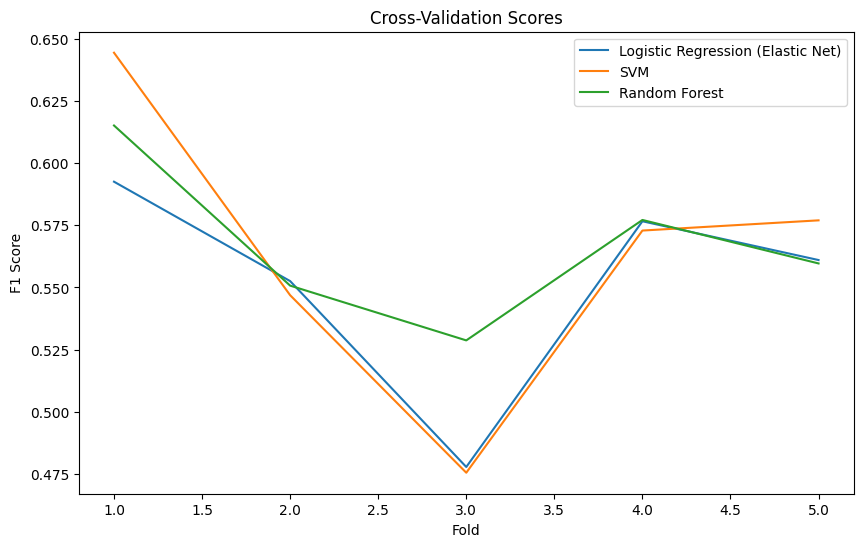

In [10]:
# Cross-validation
cv_results = {model_name: cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted') for model_name, model in models.items()}
plt.figure(figsize=(10, 6))
for model_name, scores in cv_results.items():
    plt.plot(range(1, 6), scores, label=model_name)
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Cross-Validation Scores')
plt.legend()
plt.show()

##### Comments:
The cross-validation scores show the variability of the F1 score across different folds for each model. It helps in understanding the stability of the models and their expected performance on unseen data.

#### 5.2 Learning Curves
Learning curves plot the training and validation scores of a model for varying sizes of the training dataset. They provide insight into how well the model is learning and whether it suffers from high bias (underfitting) or high variance (overfitting).

### Learning Curves


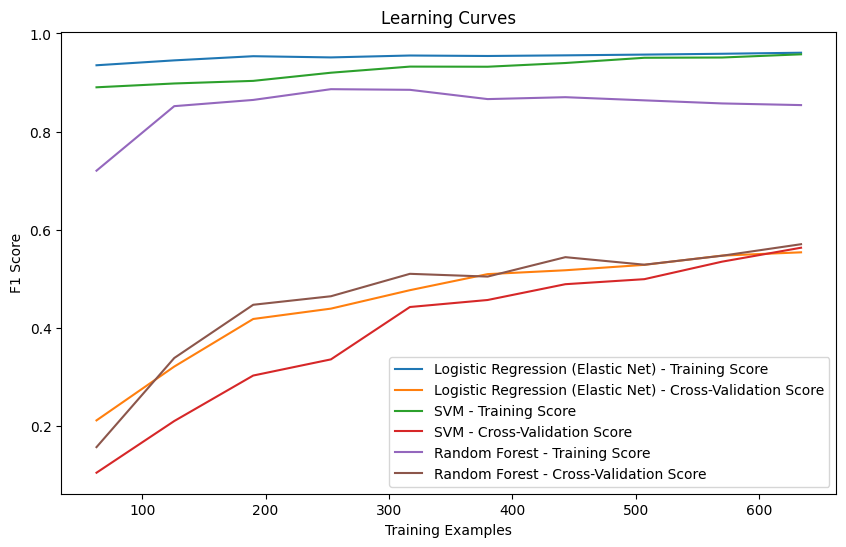

In [48]:
# Learning Curves
print("### Learning Curves")
train_sizes = np.linspace(0.1, 1.0, 10)
plt.figure(figsize=(10, 6))
for model_name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='f1_weighted')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label=f'{model_name} - Training Score')
    plt.plot(train_sizes, test_scores_mean, label=f'{model_name} - Cross-Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

##### Comments:
The learning curves indicate that all models improve as the training set size increases. Logistic Regression shows stable performance with both training and validation scores close to each other, indicating a good fit. The SVM and Random Forest models also show consistent improvement, with Random Forest performing slightly better as the training data increases.

#### 5.3 Feature Importance
Feature importance gives insights into which features contribute the most to the model's predictions. It is particularly useful in models like Random Forest, where it can highlight the most influential features in decision making.

### Feature Importance


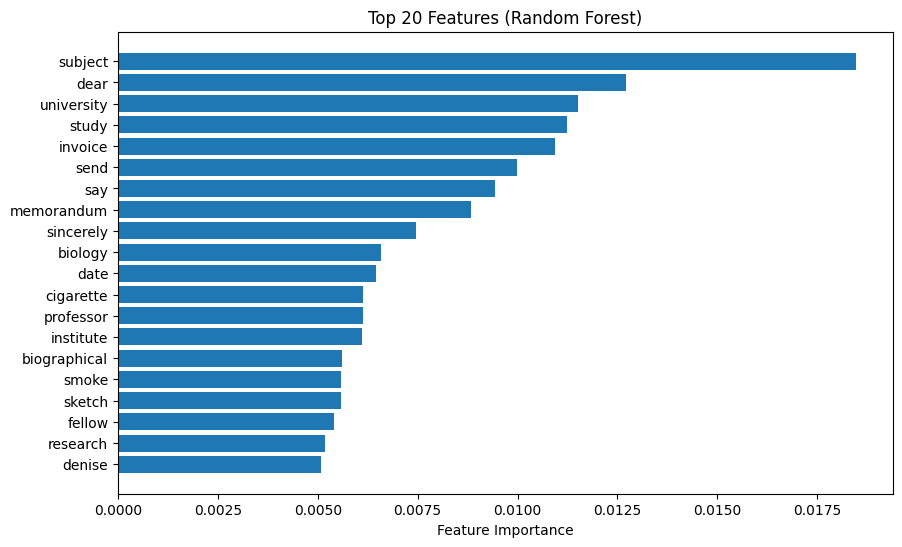

In [49]:

# Feature importance for Random Forest
print("### Feature Importance")
plt.figure(figsize=(10, 6))
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [vectorizer.get_feature_names_out()[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features (Random Forest)')
plt.show()

##### Comments:
The feature importance plot for the Random Forest model highlights the top 20 features that are most influential in predicting the target classes. This can be useful for feature selection and understanding the underlying patterns in the data.

#### 5.4 Confusions Matrix
A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This provides a more detailed insight into how well the classification model is performing.

### Confusion Matrix


<Figure size 1000x600 with 0 Axes>

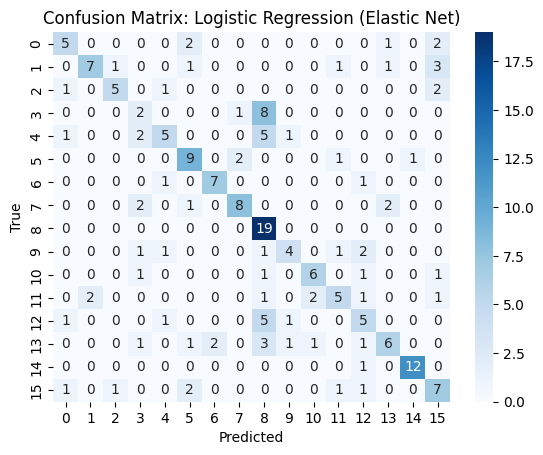

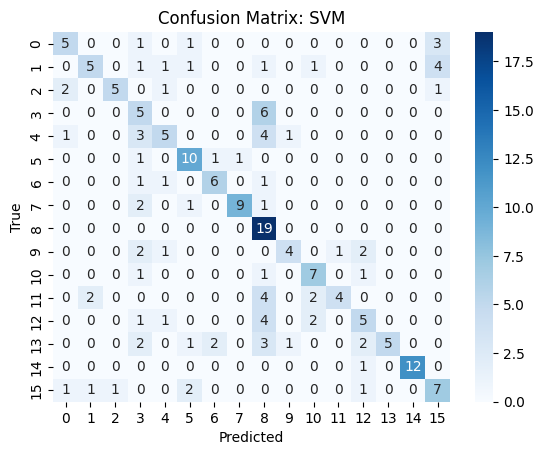

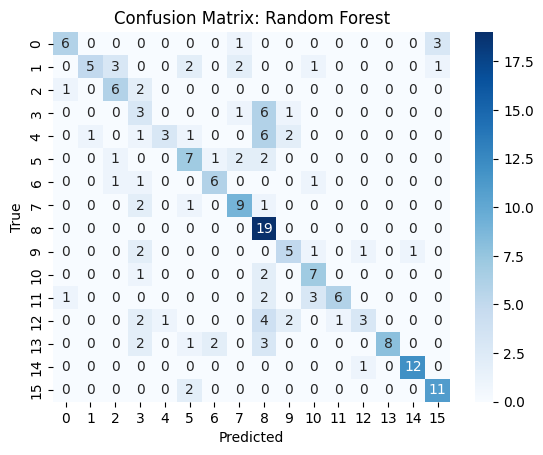

In [51]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
print("### Confusion Matrix")
plt.figure(figsize=(10, 6))
for model_name, model in models.items():
    plt.figure()
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(16))
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=np.arange(16), yticklabels=np.arange(16))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

##### Comments:
The confusion matrices for Logistic Regression (Elastic Net), SVM, and Random Forest models show the distribution of true vs. predicted labels. The diagonal elements represent correct predictions, while off-diagonal elements indicate misclassifications. All models show reasonable performance, with Random Forest having slightly better overall performance.

#### 5.5 ROC
The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate against the false positive rate at various threshold settings.

### ROC


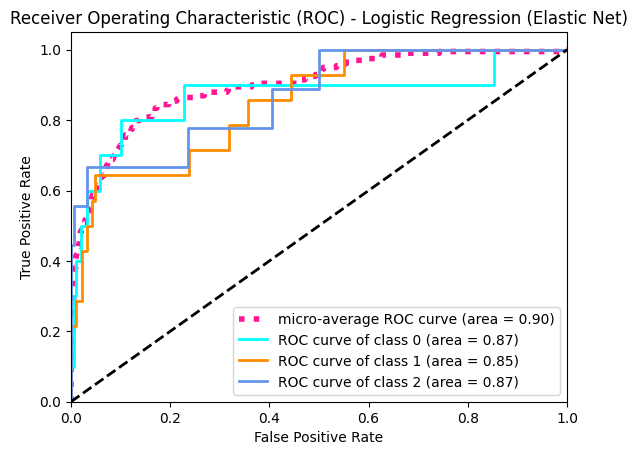

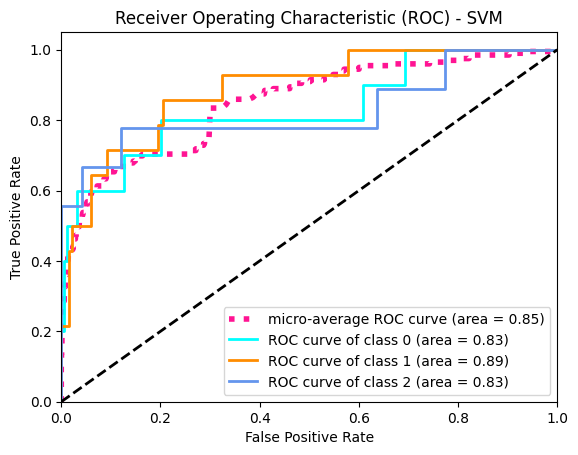

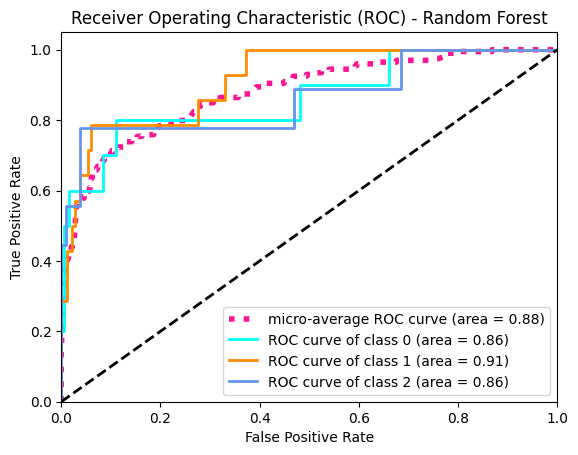

In [55]:
# ROC
print("### ROC")

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import auc

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.arange(16))

# Models from optimized results
best_logreg_elasticnet = optimized_results["Logistic Regression Elastic Net"]["Best Estimator"]
best_svm = optimized_results["SVM"]["Best Estimator"]
best_rf = optimized_results["Random Forest"]["Best Estimator"]

# Wrap models with OneVsRestClassifier for ROC evaluation
models = {
    "Logistic Regression (Elastic Net)": OneVsRestClassifier(best_logreg_elasticnet),
    "SVM": OneVsRestClassifier(best_svm),
    "Random Forest": OneVsRestClassifier(best_rf)
}

# Fit the models
for model_name, model in models.items():
    model.fit(X_train, label_binarize(y_train, classes=np.arange(16)))

# Train and evaluate models
for model_name, model in models.items():
    y_score = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(16):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

##### Comments:
The ROC curves for Logistic Regression (Elastic Net), SVM, and Random Forest models show the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The area under the curve (AUC) is a measure of how well the model distinguishes between classes. Higher AUC values indicate better performance, with all three models performing reasonably well.